In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42)

In this notebook, we will take a look at convolutional neural networks and implement some examples to get a better feeling of how they work.

As we have discussed, a CNN is defined by banks of filters that are passed (convolved) over the image. The output of the filters is then typically pooled to reduce the spatial dimension, and then passed into another set of filters.

The first such network was the famous LeNet, built by Yann LeCun in the late 1980s:

![LeNet](lenet.png)

The network that re-ignited the interest in CNNs was the AlexNet built in 2012:

![AlexNet](alexnet.jpeg)

# Classifying objects

In the following, we will use the old-school CIFAR-10 dataset that contains low-resolution pictures of objects of 10 categories. This - and other - dataset is available as part of the `torchvision` package, which you should install.

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
from torchvision import datasets, transforms, utils
# where to put the data
data_path = './'

# this constructs a CIFAR10 dataset, selects the training part of it,
# downloads it if necessary, and adds additional transforms that we
# will need to convert each image to a pytorch tensor AND to provide
# a nice conversion of the RGB images into greyscale
cifar10 =  datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

100.0%


Extracting ./cifar-10-python.tar.gz to ./


This has now downloaded the images if not already done so - you will notice that this is quite a "hefty" dataset already at 170MB. Now let's download our validation set or test set.

In [6]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


## Two-class problem

Let's make it simple first and classify just two classes for fun. We will be creating two smaller versions of the datasets and remap the label numbers.

In [7]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

## Two-class problem with fully-connected networks

Let's make it simple again and try to train a standard, fully-connected neural network. We know that we need some hidden layer, so let's get one with 512 neurons and connect that to an output layer that uses the `LogSoftmax` final output from Pytorch, which - when combined with a `NLLLoss` gives us exactly cross entropy.

This is a bit confusingly defined in pytorch, and most models - as we will see below - do this in a different way to make it easier to set up the classification problem with a cross-entropy loss.

In [9]:
first_model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1))

numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

### Dataloaders

This is a very nice convenience function that allows you to stick a properly prepared dataset and automatically use it to load batches from it for training and testing.

In [10]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

So, now let's define our training loop combining the softmax loss with a negative log likelihood loss to get our overall cross-entropy type classification going:

In [11]:
learning_rate = 1e-2
optimizer = optim.SGD(first_model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = first_model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.474819
Epoch: 1, Loss: 0.281294
Epoch: 2, Loss: 0.532767
Epoch: 3, Loss: 0.703840
Epoch: 4, Loss: 0.637057
Epoch: 5, Loss: 0.293572
Epoch: 6, Loss: 0.442983
Epoch: 7, Loss: 0.454170
Epoch: 8, Loss: 0.223838
Epoch: 9, Loss: 0.397415
Epoch: 10, Loss: 0.299176
Epoch: 11, Loss: 0.352056
Epoch: 12, Loss: 0.253029
Epoch: 13, Loss: 0.234517
Epoch: 14, Loss: 0.168960
Epoch: 15, Loss: 0.215394
Epoch: 16, Loss: 0.141173
Epoch: 17, Loss: 0.452234
Epoch: 18, Loss: 0.373207
Epoch: 19, Loss: 0.231367
Epoch: 20, Loss: 0.428932
Epoch: 21, Loss: 0.257102
Epoch: 22, Loss: 0.162273
Epoch: 23, Loss: 0.151934
Epoch: 24, Loss: 0.267510
Epoch: 25, Loss: 0.346485
Epoch: 26, Loss: 0.190525
Epoch: 27, Loss: 0.217803
Epoch: 28, Loss: 0.258378
Epoch: 29, Loss: 0.121026
Epoch: 30, Loss: 0.326386
Epoch: 31, Loss: 0.213834
Epoch: 32, Loss: 0.180499
Epoch: 33, Loss: 0.172872
Epoch: 34, Loss: 0.101905
Epoch: 35, Loss: 0.513520
Epoch: 36, Loss: 0.112536
Epoch: 37, Loss: 0.215815
Epoch: 38, Loss: 0.047

This seems to "nicely" reduce the loss. But of course this loss is not the same as accuracy as we discussed before. So, let's evaluate the accuracy on our validation set:

In [12]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = first_model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy:", correct / total)

Accuracy: 0.8195


Depending on the run, this will result in a performance of around 80% - certainly not perfect, but also not fully random.

Can we do better? Of course, let's go deep! More parameters, more layers, more features that can be discovered.

In [13]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))
loss_fn = nn.CrossEntropyLoss()

So, here we have a model that goes nicely deeper, reducing the number of hidden layer neurons by factors of two each time and culminating in the two-outputs for the neurons.

We have also now included a linear layer as our final output and directly use the cross-entropy loss function. When doing so, the only downside is that we cannot of course interpret the outputs of our final, linear layer as probabilities for class membership (as is possible in our previous architecture!).

How many parameters do we have now?

In [14]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

That's a LOT. Over 3 million parameters to train. And of course the first hidden layer with 1024 hidden neurons has the most parameters, as it connects each pixel (3072) to each neuron.

So that's of course 3072 * 1024 + 1024 parameters, which we can check directly like so:

In [15]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

Let's train this biggy:

In [16]:
learning_rate = 1e-2
optimizer = optim.SGD(connected_model.parameters(), lr=learning_rate)
n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = connected_model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.517441
Epoch: 1, Loss: 0.374051
Epoch: 2, Loss: 0.550148
Epoch: 3, Loss: 0.304952
Epoch: 4, Loss: 0.612046
Epoch: 5, Loss: 0.615093
Epoch: 6, Loss: 0.309578
Epoch: 7, Loss: 0.273005
Epoch: 8, Loss: 0.307623
Epoch: 9, Loss: 0.640262
Epoch: 10, Loss: 0.457685
Epoch: 11, Loss: 0.282848
Epoch: 12, Loss: 0.552834
Epoch: 13, Loss: 0.356408
Epoch: 14, Loss: 0.666543
Epoch: 15, Loss: 0.166197
Epoch: 16, Loss: 0.395621
Epoch: 17, Loss: 0.349817
Epoch: 18, Loss: 0.136748
Epoch: 19, Loss: 0.287811
Epoch: 20, Loss: 0.321492
Epoch: 21, Loss: 0.645440
Epoch: 22, Loss: 0.785450
Epoch: 23, Loss: 0.096930
Epoch: 24, Loss: 0.152845
Epoch: 25, Loss: 0.340590
Epoch: 26, Loss: 0.335306
Epoch: 27, Loss: 0.228111
Epoch: 28, Loss: 0.186797
Epoch: 29, Loss: 0.203634
Epoch: 30, Loss: 0.149932
Epoch: 31, Loss: 0.086028
Epoch: 32, Loss: 0.098715
Epoch: 33, Loss: 0.134205
Epoch: 34, Loss: 0.329507
Epoch: 35, Loss: 0.472854
Epoch: 36, Loss: 0.180600
Epoch: 37, Loss: 0.105622
Epoch: 38, Loss: 0.121

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = connected_model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy:", correct / total)

Accuracy: 0.8105


We have not achieved a massive reduction in validation error - even though in most cases, we will be able to reduce the **training** error to 0.

So, we are massively overfitting our training set, apparently, producing a model that can perfectly "remember" all the relationships between pixels for the training data, but fails to generalize properly to the validation/test data.

Why is this again?

It is because our network, for example, cannot deal with something as simple as a translation of image content. Our network has been trained to capture the distribution of the exact locations of pixels in the image. Even a slight shift will result in something unpredictable.

So, this motivated the idea of using networks with convolutional filters, where smaller filters are shared across the whole image.

## Convolutions in Pytorch

Let's first take a look at how convolutions are defined in Pytorch:

In [18]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

This as we can see is a **layer**, which uses 16 filters, each of size 3x3 pixels on a three-channel image. The stride is set to 1 in both x and y-direction, and there is **no padding**.

The number of learnable parameters should hence be 16 filters * 3 color channels * 3x3 pixels + 16 biases:

In [19]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

So, let's convolve the first image of CIFAR with our layer:

In [20]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))

And we can show the output and the input like so:

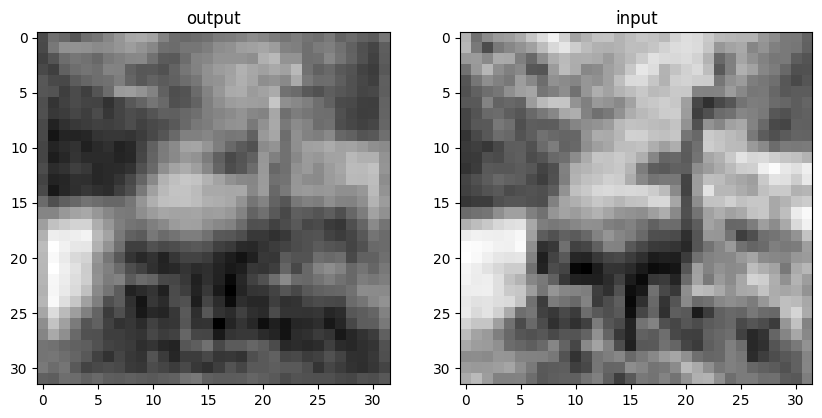

In [21]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

A few things to note: first of all, weights and biases of the convolution layer have been randomly initialized, so the output is not going to be very meaningful.

Second of all, as is easily noticable, the dimensionality of input and output is not the same:

In [22]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

The reason is of course that we lose pixels around the edge due to the convolution operation. The solution then is to add padding to the image. Since, we have a kernel size of 3x3, we need a padding of 1 pixel.

Let's implement this:

In [23]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

We can of course force the filters to a certain value. Let's do this manually, setting the biases to 0 and the weights to normalized similar values.

In [24]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

And it's pretty clear what this will give us, right?

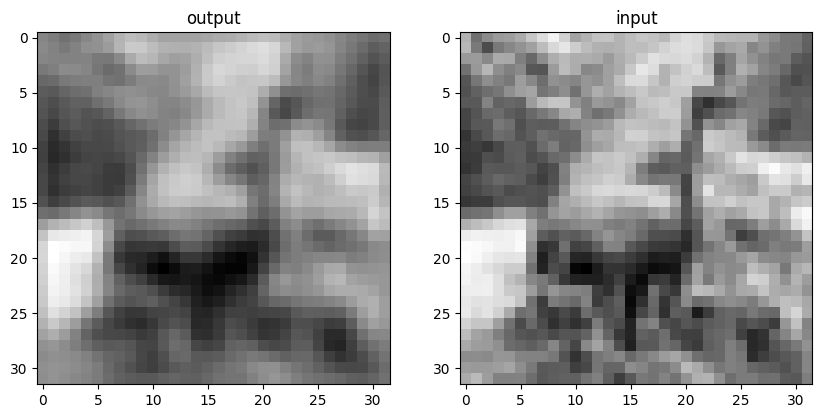

In [25]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

Let's do a bit of edge detection:

In [26]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

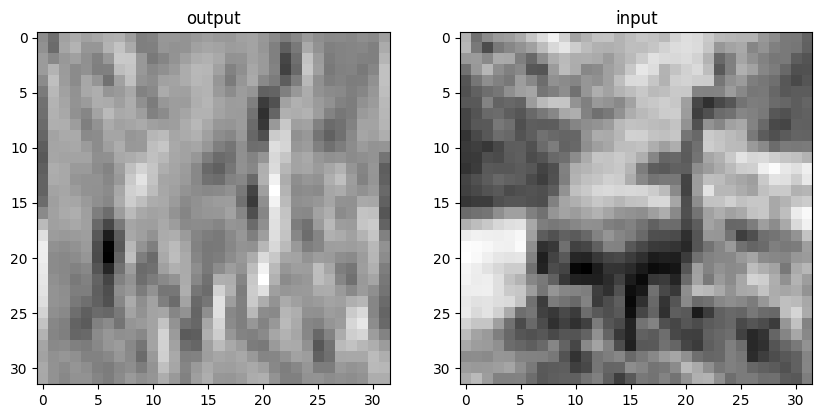

In [27]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

## Derivatives of convolution filter layers

If we assume that our convolution written as an operator $*$ works on an input $X$ to produce an output $O$ using a filter $F$ like so:

$$
O = F * X
$$


where we assume that our filter $F$ is square with $n$ elements and thus we have:

$$
O_{i,j}=\sum_{k=-n}^{n} \sum_{l=-n}^{n} F_{k,l}X_{i+k,j+l}
$$

In order to do the backpropagation, we are given the loss $\frac{\partial L}{\partial O}$ from a previous layer. We now have to push this through the convolution to get two things:

$$
...
$$

and

$$
...
$$

To make matters more "visible", we are going to use a simple example of a 3x3 input matrix $X$ and a 2x2 filter $F$. So, for the first element of the output $O_{1,1}$, we get:

$$
O_{1,1}=X_{1,1}F_{1,1}+X_{1,2}F_{1,2}+X_{2,1}F_{2,1}+X_{2,2}F_{2,2}
$$

and, similarly, for the remaining elements:

$$
O_{1,2}=X_{1,2}F_{1,1}+X_{1,3}F_{1,2}+X_{2,2}F_{2,1}+X_{2,3}F_{2,2}
$$

$$
O_{2,1}=X_{2,1}F_{1,1}+X_{2,2}F_{1,2}+X_{3,1}F_{2,1}+X_{3,2}F_{2,2}
$$

$$
O_{2,2}=X_{2,2}F_{1,1}+X_{2,3}F_{1,2}+X_{3,2}F_{2,1}+X_{3,3}F_{2,2}
$$


### Finding $\frac{\partial L}{\partial F}$
So, first, the partial derivative to update our filter $F$ can be expanded using the chain rule:

$$
\frac{\partial L}{\partial F} = \frac{\partial L}{\partial O} \cdot \frac{\partial O}{\partial F}
$$

As written above, both $O$ and $F$ are of course matrices - when doing this, we can expand the derivatives like so, for every element of $F$, we have:

$$
\frac{\partial L}{\partial F_i} = \sum_{k=1}^{n} \frac{\partial L}{\partial O_k} \cdot \frac{\partial O_k}{\partial F_i}
$$


now we can take the derivatives with respect to each filter coefficent $F_{i,j}$ to find:

$$
\frac{\partial O_{1,1}}{\partial F_{i,j}}=X_{i,j}
$$

Watch out though, the derivatives for the next element is not "that easy" anymore:

$$
O_{1,2}=X_{1,2}F_{1,1}+X_{1,3}F_{1,2}+X_{2,2}F_{2,1}+X_{2,3}F_{2,2}
$$

For this, the derivatives with respect to each filter coefficent $F_{i,j}$ yields different elements of the input matrix!


so, now we need to go into the matrix derivatives. Using the definition of the matrix derivative, we get for the following four partial derivatives:


$$
\frac{\partial L}{\partial F_{1,1}}=\frac{\partial L}{\partial O_{1,1}}\frac{\partial O_{1,1}}{\partial F_{1,1}}+\frac{\partial L}{\partial O_{1,2}}\frac{\partial O_{1,2}}{\partial F_{1,1}}+\frac{\partial L}{\partial O_{2,1}}\frac{\partial O_{2,1}}{\partial F_{1,1}}+\frac{\partial L}{\partial O_{2,2}}\frac{\partial O_{2,2}}{\partial F_{1,1}}
$$

$$
\frac{\partial L}{\partial F_{1,2}}=\frac{\partial L}{\partial O_{1,1}}\frac{\partial O_{1,1}}{\partial F_{1,2}}+\frac{\partial L}{\partial O_{1,2}}\frac{\partial O_{1,2}}{\partial F_{1,2}}+\frac{\partial L}{\partial O_{2,1}}\frac{\partial O_{2,1}}{\partial F_{1,2}}+\frac{\partial L}{\partial O_{2,2}}\frac{\partial O_{2,2}}{\partial F_{1,2}}
$$

$$
\frac{\partial L}{\partial F_{2,1}}=\frac{\partial L}{\partial O_{1,1}}\frac{\partial O_{1,1}}{\partial F_{2,1}}+\frac{\partial L}{\partial O_{1,2}}\frac{\partial O_{1,2}}{\partial F_{2,1}}+\frac{\partial L}{\partial O_{2,1}}\frac{\partial O_{2,1}}{\partial F_{2,1}}+\frac{\partial L}{\partial O_{2,2}}\frac{\partial O_{2,2}}{\partial F_{2,1}}
$$

$$
\frac{\partial L}{\partial F_{2,2}}=\frac{\partial L}{\partial O_{1,1}}\frac{\partial O_{1,1}}{\partial F_{2,2}}+\frac{\partial L}{\partial O_{1,2}}\frac{\partial O_{1,2}}{\partial F_{2,2}}+\frac{\partial L}{\partial O_{2,1}}\frac{\partial O_{2,1}}{\partial F_{2,2}}+\frac{\partial L}{\partial O_{2,2}}\frac{\partial O_{2,2}}{\partial F_{2,2}}
$$

we know the second parts of these derivatives and can plug them in like so:



$$
\frac{\partial L}{\partial F_{1,1}}=\frac{\partial L}{\partial O_{1,1}}\cdot X_{1,1}+\frac{\partial L}{\partial O_{1,2}}\cdot X_{1,2}+\frac{\partial L}{\partial O_{2,1}}\cdot X_{2,1}+\frac{\partial L}{\partial O_{2,2}}\cdot X_{2,2}
$$

$$
\frac{\partial L}{\partial F_{1,2}}=\frac{\partial L}{\partial O_{1,1}}\cdot X_{1,2}+\frac{\partial L}{\partial O_{1,2}}\cdot X_{1,3}+\frac{\partial L}{\partial O_{2,1}}\cdot X_{2,2}+\frac{\partial L}{\partial O_{2,2}}\cdot X_{2,3}
$$

$$
\frac{\partial L}{\partial F_{2,1}}=\frac{\partial L}{\partial O_{1,1}}\cdot X_{2,1}+\frac{\partial L}{\partial O_{1,2}}\cdot X_{2,2}+\frac{\partial L}{\partial O_{2,1}}\cdot X_{3,1}+\frac{\partial L}{\partial O_{2,2}}\cdot X_{3,2}
$$

$$
\frac{\partial L}{\partial F_{2,2}}=\frac{\partial L}{\partial O_{1,1}}\cdot X_{2,2}+\frac{\partial L}{\partial O_{1,2}}\cdot X_{2,3}+\frac{\partial L}{\partial O_{2,1}}\cdot X_{3,2}+\frac{\partial L}{\partial O_{2,2}}\cdot X_{3,3}
$$

So, we have four partial derivatives, which you can represent nicely as the result of **another convolution** between the input matrix $X$ and another filter $F'$ that consists of the partial derivatives of the loss with respect to each of the outputs

$$
...
$$


### Finding $\frac{\partial L}{\partial X}$
So, second, the partial derivative to backpropagate the loss with respect to the input $X$, we expand using the chain rule:

$$
\frac{\partial L}{\partial X} = \frac{\partial L}{\partial O} \cdot \frac{\partial O}{\partial X}
$$


Again, these are all matrices - so, for every element of $X$, we have:

$$
\frac{\partial L}{\partial X_i} = \sum_{k=1}^{n} \frac{\partial L}{\partial O_k} \cdot \frac{\partial O_k}{\partial X_i}
$$

From the forward equations of the convolution, we find for the first element:

$$
\frac{\partial O_{1,1}}{\partial X_{i,j}}=F_{i,j}
$$

we now get nine(!) different terms:

$$
\frac{\partial L}{\partial X_{1,1}} = \frac{\partial L}{\partial O_{1,1}} \cdot F_{1,1}
$$

$$
\frac{\partial L}{\partial X_{1,2}} = \frac{\partial L}{\partial O_{1,1}} \cdot F_{1,2} + \frac{\partial L}{\partial O_{1,2}} \cdot F_{1,1}
$$

$$
\frac{\partial L}{\partial X_{1,3}} = \frac{\partial L}{\partial O_{1,2}} \cdot F_{1,2}
$$

$$
\frac{\partial L}{\partial X_{2,1}} = \frac{\partial L}{\partial O_{1,1}} \cdot F_{2,1} + \frac{\partial L}{\partial O_{2,1}} \cdot F_{1,1}
$$

$$
\frac{\partial L}{\partial X_{2,2}} = \frac{\partial L}{\partial O_{1,1}} \cdot F_{2,2} + \frac{\partial L}{\partial O_{1,2}} \cdot F_{2,1} + \frac{\partial L}{\partial O_{2,1}} \cdot F_{1,2} + \frac{\partial L}{\partial O_{2,2}} \cdot F_{1,1}
$$

$$
\frac{\partial L}{\partial X_{2,3}} = \frac{\partial L}{\partial O_{1,2}} \cdot F_{2,2} + \frac{\partial L}{\partial O_{2,2}} \cdot F_{1,2}
$$

$$
\frac{\partial L}{\partial X_{3,1}} = \frac{\partial L}{\partial O_{2,1}} \cdot F_{2,1}
$$

$$
\frac{\partial L}{\partial X_{3,2}} = \frac{\partial L}{\partial O_{2,1}} \cdot F_{2,2} + \frac{\partial L}{\partial O_{2,2}} \cdot F_{2,1}
$$

$$
\frac{\partial L}{\partial X_{3,3}} = \frac{\partial L}{\partial O_{2,2}} \cdot F_{2,2}
$$


This funnily enough is also a type of convolution of the loss gradient matrix $F^{'}_{i,j} = \frac{\partial L}{\partial O_{i,j}}$, but this time with a rotated version of the original filter $R$!

So, our rotated filter $R$ is obtained by flipping $F$ first vertically and then horizontally to get:

$$
R_{1,1}=F_{2,2}
$$

$$
R_{1,2}=F_{2,1}
$$

$$
R_{2,1}=F_{1,2}
$$

$$
R_{2,2}=F_{1,1}
$$

Now we slide this 2x2 filter across the our $F'$, which looks like this:

![full convolution - copyright @pavisj](fullconv.gif)

This is sometimes called a **full convolution**.

### The full backpropagation

So, in summary, our backpropagation needs two terms that can be obtained by convolutions.

1. A simple convolution of the values coming on from high with the original input $X$.

2. A full convolution of the values coming on from high with a rotated version of the original filter $F$.


For another, very in-depth derivation of this, you can also refer to:

https://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/

## Going deep

Great, so now that we know how to derive the operation of discrete convolution filters, we can try to make a neural network with convolution layers!

The issue is, however, that the filters that we used here in this layer are 3x3 pixels. How can we make sure that 3x3 pixels are actually sufficient to explain all types of important image features?

We cannot make sure - in fact, if you look at birds versus airplanes, as our network here is supposed to do, then almost certainly we would assume that certain structures of these image categories are larger in extent (think about the wings of the aircraft, or the "body" of birds, etc).

One solution to this will of course be to make **larger** filters - CIFAR is 32x32 pixels, so we could - in principle - go all the way up to 32x32 pixels for our filters. This, however, will be very inefficient, as it will be exactly the same as a fully-connected network (in fact, much "worse", since we have 16 of these filters).

So, like we have seen at the very beginning of the notebook, people proposed to go deep, successively reducing the size of the image so that filters become "larger" in each layer.

We can do this downsampling operation between layers in a variety of ways:

1. Average the results in a small area and then downsample - this is called average pooling

2. Take the maximum of the results in a small area (say 4x4 pixels) and use this as the downsample value - this is called max pooling

3. Do a so-called **strided** convolution, in which the filter is not evaluated at each pixel, but "skips" input pixels.

The most common approach for standard CNNs is to downsample using max-pooling.

This is what that looks like as a layer in Pytorch:

In [28]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

And this is what happens if you have two subsequent layers of convolutions with max-pooling on a 2x2 scale.

![maxpool](maxpool.png)

In the final layer of max-pooling, the number 21 is produced from the data coming from an original part of the image of 8x8 pixels!

Note, how the max-pooling keeps the spatial information intact such that we can actually say that something cross-like seemed to be happening at the top-left of the image.


### Derivatives of max-pooling

In order to do backpropagation, we need to of course know the value of the derivative of this operation. Well, in this case, this is simple as the error is assigned to all the neuron/unit that contributed the "max". All other neurons/units did not do anything to the forward pass, and hence their backpropagation value will be 0.

### Implementation

So, in Pytorch, we will now be doing something like this:

In [29]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2))

The problem here is that we now need to convert the output of the final max-pooling, which are 2D-like into a 1D vector that we need to convert to probabilities somehow.

Maybe like this???

In [30]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

So, here, we've added two sets of linear layers that will now take the output of the max-pooling to somehow create internal features that we can then map onto two classes (or more, of course).


How many parameters do we have now??

In [31]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Awww. That's cute, no? Instead of 1.5 or 3 million parameters as before, we have just over 18,000 parameters. This of course, does not mean that our network can solve the birds versus airplane task - it's just that we have set it up like this.

But there is something missing: in order to check this, let's try to apply this randomly-initialized model to an image:

In [33]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

That gives a nasty error. In fact, pytorch complains that the output of the max-pool and the linear layer do not seem to be compatible.

There are two ways to remedy this: the first is the old-school way, in which we manually reshape the output of the max-pool layer so that it conforms to an input-ready shape for the linear layer.

For the old-school version, we have to build a sub-class `nn.Module` and then put a `view` command like this:

In [35]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

And here is how we find out how many parameters our model has:

In [36]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

And here is the output of the image being passed through the network (without the loss layer!):

In [37]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0363, -0.1197]], grad_fn=<AddmmBackward0>)

The second, newer way is to simply use the Pytorch `nn.Flatten` layer that achieves the same thing:

In [38]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.flatten(out)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [39]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0608,  0.1396]], grad_fn=<AddmmBackward0>)

Instead of using layers to do the calculations of the activation functions and the max-pooling, you can also use them as operators in the forward function, which may be more satisfactory from a coding point of view, as these "layers" don't actually have a lot of parameters.

In [40]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

The fun with CNNs is to determine how to calculate the output of the stacked layers of convolutions and max-pooling operations.

Here's a handy function that does this automatically for you:

In [41]:
def flatten(w, k=3, s=1, p=0, m=True):
    """
    Returns the right size of the flattened tensor after
        convolutional transformation
    :param w: width of image
    :param k: kernel size
    :param s: stride
    :param p: padding
    :param m: max pooling (bool)
    :return: proper shape and params: use x * x * previous_out_channels

    Example:
    r = flatten(*flatten(*flatten(w=100, k=3, s=1, p=0, m=True)))[0]
    self.fc1 = nn.Linear(r*r*128, 1024)
    """
    
    
    return int((np.floor((w - k + 2 * p) / s) + 1) / 2 if m else 1), k, s, p, m

## Two-class problem with convolutions

Let's finally go to an implementation using our newly-minted CNN:

In [42]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            # put a batch through the model
            outputs = model(imgs)
            # determine the loss
            loss = loss_fn(outputs, labels)
            # zero the gradients and determine backpropagation
            optimizer.zero_grad()
            loss.backward()
            # do one step of optimization
            optimizer.step()
            # keep track of the loss
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

Now, let's train this (small) convolutional neural network with this training_loop class for 100 epochs:

In [43]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

# get the model
model = Net()
# standard optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-2)
# classification loss
loss_fn = nn.CrossEntropyLoss()

# go for 100 epochs
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-11-09 11:02:32.005987 Epoch 1, Training loss 0.5691338790829774
2023-11-09 11:02:45.013019 Epoch 10, Training loss 0.32627861723778356
2023-11-09 11:03:00.333874 Epoch 20, Training loss 0.2945275458560628
2023-11-09 11:03:15.542880 Epoch 30, Training loss 0.2693385776061161
2023-11-09 11:03:30.847262 Epoch 40, Training loss 0.2510661807409517
2023-11-09 11:03:46.079348 Epoch 50, Training loss 0.23153182811987627
2023-11-09 11:04:01.558086 Epoch 60, Training loss 0.21550593140778268
2023-11-09 11:04:16.921397 Epoch 70, Training loss 0.20257563011091986
2023-11-09 11:04:32.311022 Epoch 80, Training loss 0.1847280766933587
2023-11-09 11:04:47.174402 Epoch 90, Training loss 0.17269827330568036
2023-11-09 11:05:03.416785 Epoch 100, Training loss 0.15875883445523348


That takes a little time, but we can see that the error is going down. Loss is, however, not very intuitive to parse for humans, so let's convert to accuracies on training and testing:

In [44]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


Wow, our tiny model with only 18,000 parameters is actually doing quite well. The power of the filters!!

Let's save this model using Pytorch like so (this will require the full model class for instantiation):

In [46]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [47]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

### Visualizing the filters

We have now trained a bunch of filters. What do they look like?

First, a helper function:

In [48]:
plt.rcParams["savefig.bbox"] = 'tight'

import torchvision.transforms.functional as F1
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F1.to_pil_image(img[0,:,:])
        axs[0, i].imshow(np.asarray(img),cmap='gray')
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Now let's visualize the filters from a first convolutional layer:

In [49]:
model.conv1.weight.shape

torch.Size([16, 3, 3, 3])

What about the second layer?

In [50]:
model.conv2.weight.shape

torch.Size([8, 16, 3, 3])

In order to come up with a "better" intuition, let's turn to a bigger training exercise and take a look at a breakout link:

### Breakout

https://cs.stanford.edu/people/karpathy/convnetjs/